## a sub-diffusion code

Producing a self similar analytic solution as $u(x,t)=B(x,t)$ where $B(x,t)$ is a Baranblatt profile, a separable solution $u(x,t)=\frac{-x^2}{6t}$, and a solution similar to the Barenblat profile $u(x,t)=\frac{1}{6}\left[Ct^{-1/3}-\frac{x^2}{t}\right]$.

In [12]:
function barenblatt(x::Float64, t::Float64)
    A=0.16666666666666
    if A >= ((x^2)/(6*(t^0.666666)))
        return (t^(-0.333333333))*(A-((x^2)/(6*(t^0.666666))))
    else
        return 0
    end
end;

function B(x::Array{Float64,1},t::Float64)
    return map(u->barenblatt(u,t),x)
end;

Separable(x,t)=-x^2/(6*t)
SSol(x,t)=map(a->Separable(a,t),x)
Barenblatt_like(x,t)=0.166666666*((6.0/(t^0.333333333))- (x^2)/t)
blSol(x,t)=map(a->Barenblatt_like(a,t),x)

blSol (generic function with 1 method)

In [13]:
X=collect(-499:500);
X=map(x->0.01*x,X);


In [14]:
import Pkg; Pkg.add("Plots");
using Plots;

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % [=========>                               ]  20.8 %]  41.3 % [========================>                ]  59.0 %]  79.6 % Resolving package versions...
 Installed WeakRefStrings ─ v0.5.6
 Installed DataFrames ───── v0.17.1
 Installed Mustache ─────── v0.5.11
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [a93c6f00] ↑ DataFrames v0.17.0 ⇒ v0.17.1
  [ffc61752] ↑ Mustache v0.5.10 ⇒ v0.5.11
  [ea10d353] ↑ WeakRefStrings v0.5.5 ⇒ v0.5.6


┌ Info: Recompiling stale cache file /astro/lovascio/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1187
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [15]:

gr()


Plots.GRBackend()

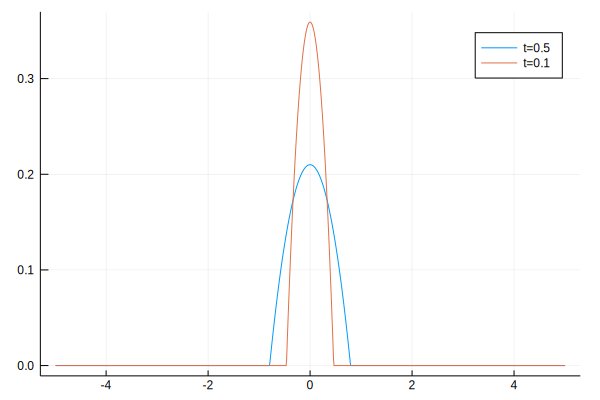

In [39]:
BB=B(X,0.1)
plot(X,B(X,0.5),label="t=0.5")
plot!(X,B(X,0.1),label="t=0.1")

#### Globals

In [16]:
h=0.1;
NGH=1;

#### Boundary conditions

In [17]:
function Constant(u::Array{Float64,1},x::Array{Float64,1},t::Float64,K::Float64)
    return K,K
end

function Time_dependant_diffusion(u::Array{Float64,1},x::Array{Float64,1},t::Float64)
    return (-(x[1]^2)/(6.0*t)),(-(x[end]^2)/(6.0*t))
end

function bl_Bound(u::Array{Float64,1},x::Array{Float64,1},t::Float64)
    return Barenblatt_like(x[1],t), Barenblatt_like(x[end],t)
end

#Bound(u,x,t)=Constant(u,x,t,0.0)
Bound(u,x,t)=bl_Bound(u,x,t)

Bound (generic function with 1 method)

#### Spatial discretistion and functions -Central Finite Differences-

In [18]:
∂ₓ(u::Array{Float64,1},i::Int64) = (u[i+1]-u[i-1])/(2.0*h)
∂ₓₓ(u::Array{Float64,1},i::Int64) = (u[i+1]-2.0*u[i]+u[i-1])/(h^2)

D(A::Float64) = A
F(u::Array{Float64,1},i::Int64) = D(u[i])*∂ₓₓ(u,i) + ∂ₓ(u,i)^2
P_dot(p::Array{Float64,1},i::Int64) = D(1.0-p[i])*∂ₓₓ(p,i) - ∂ₓ(p,i)*∂ₓ(p,i)

P_dot (generic function with 1 method)

#### Time integration -RKL2-

In [37]:
function b(j)
    J=convert(Float64,j)
    if j < 3
        B=0.33333333333333333
    else
        B=(J^2 + J -2)/(2J*(J+1))
    end
    return B
end

function w(s)
    S=convert(Float64,s)
    W=4/(S^2 + S -2)
    return W
end

function μ(j)
    J=convert(Float64,j)
    MU=((2J-1)/J)*(b(j)/b(j-1))
    return MU
end

function ν(j)
    J=convert(Float64,j)
    NU=-((J-1)/J)*(b(j)/b(j-2))
    return NU
end

μ_2(j,s)=μ(j)*w(s)

function γ_2(j,s)
    GAM=-μ_2(j,s)*(1-b(j-1))
    return GAM
end

function current_time(j::Int,s::Int32)
    J=convert(Float64,j)
    S=convert(Float64,s)
    return (J^2+J-2)/(S^2+S-2)
end

function calc_t_parab(D::Function,D_array::Array{Float64,1},F::Array{Float64,1})
    D_array=map(x->D(x),F)
    t=maximum(abs.(D_array))
    t=0.5*abs((h^2)/t)
    return t
end

function Dot(F::Function,u::Array{Float64,1},result::Array{Float64,1})
    for i=(1+NGH):(length(u)-NGH)
        result[i]=F(u,i)
    end
    return result
end

function step_calc(τ::Float64,t_parab::Float64)
    delta=9+16*(τ/t_parab)
    #println("del=",delta)
    return convert(Int32,ceil(0.5*sqrt(delta)-0.5))
end

function RKL_step(u::Array{Float64,1},x::Array{Float64,1},t_now::Float64,
                D_array::Array{Float64,1},F::Function,D::Function,
                τ::Float64,temp::Array{Float64,2})
    s=step_calc(τ,calc_t_parab(D,D_array,u))
    #println("steps=",s)
    Y0=u
    temp[:,1]=Y0
    temp[:,2]=Y0+μ_2(1,s)*τ*Dot(F,Y0,temp[:,4])
    temp[1,1],temp[end,1]=Bound(temp[:,1],x,t_now)
    temp[1,2],temp[end,2]=Bound(temp[:,2],x,t_now)
    for j=2:s
        i=((j)%3)+1
        temp[:,i]=μ(j)*temp[:,((j-1)%3)+1] +
                          ν(j)*temp[:,((j-2)%3)+1] +
                          (1-μ(j)-ν(j))*Y0 +
                          μ_2(j,s)*τ*Dot(F,temp[:,((j-1)%3)+1],temp[:,5]) +
                          γ_2(j,s)*τ*Dot(F,Y0,temp[:,4])
        temp[1,i],temp[end,i]=Bound(temp[:,i],x,t_now+τ*current_time(j,s))
    end
    return temp[:,((s)%3)+1]
end
    
    
#function RK4_step(u::Array{Float64,1},D_array::Array{Float64,1},F::Function,D::Function,τ::Float64,temp::Array{Float64,2})
    
function nSteps(n::Int64,init::Array{Float64,1},grid::Array{Float64,1},
                t_init::Float64,DARRAY::Array{Float64,1},F::Function,
                Df::Function,τ::Float64)
    TempMatrix=zeros(length(init),5)
    u=deepcopy(init)
    time=t_init
    for i=1:n
        u=RKL_step(u,grid,time,DARRAY,F,Df,τ,TempMatrix)
        time+=τ
        #println(time,"\n")
        #Sol=hcat(Sol,u)
    end
    return u
end 
    

nSteps (generic function with 1 method)

#### Error analysis

In [31]:
∑=sum;
L1(Theoretical::Array{Float64,1}, Numerical::Array{Float64,1})=∑(abs.(Theoretical-Numerical))/convert(Float64,length(Theoretical))
Pnorm(N::Int,Theoretical::Array{Float64,1}, Numerical::Array{Float64,1})=∑(abs.(Theoretical.^N -Numerical.^N))/convert(Float64,length(Theoretical))

Pnorm (generic function with 1 method)

#### Program proper

In [21]:
τ=0.01;
t₀=1.0;

del=156808.9460394669
del=156289.73747056164
del=155777.33827689875
del=155271.5936972658
del=154772.3539468066
del=154279.47401098796
del=153792.81344996623
del=153312.2362127355
del=152837.61046048263
del=152368.80839861205
del=151905.70611694004
del=151448.18343759043
del=150996.12377015525
del=150549.41397371213
del=150107.94422531582
del=149671.60789460683
del=149240.30142420158
del=148813.92421555103
del=148392.37851997258
del=147975.56933457986
del=147563.40430285063
del=147155.79361958973
del=146752.6499400579
del=146353.8882930521
del=145959.42599773384
del=145569.18258401623
del=145183.07971632987
del=144801.04112059815
del=144422.9925142639
del=144048.86153921628
del=143678.57769747652
del=143312.07228950877
del=142949.2783550298
del=142590.1306161983
del=142234.5654230711
del=141882.52070121918
del=141533.93590140357
del=141188.75195121486
del=140846.91120858613
del=140508.35741709432
del=140173.03566296797
del=139840.89233372567
del=139511.87507837082
del=139185.9327690754

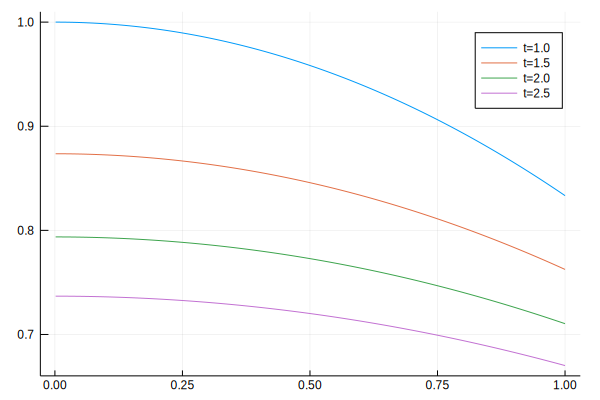

In [35]:
h=1.0/convert(Float64,700);
mesh=map(x->h*x,collect(1:700));
DARRAY=zeros(700);
u=blSol(mesh,t₀);
umin=deepcopy(u);
u=nSteps(50,umin,mesh,t₀,DARRAY,F,D,τ);
u1=nSteps(100,umin,mesh,t₀,DARRAY,F,D,τ);
u2=nSteps(150,umin,mesh,t₀,DARRAY,F,D,τ);
plot(mesh,umin,label="t=1.0")
plot!(mesh,u,label="t=1.5")
plot!(mesh,u1,label="t=2.0")
plot!(mesh,u2,label="t=2.5")

In [39]:
Norm=[]

for N ∈ collect(100:500)
    h=1.0/convert(Float64,N);
    println("h=",h)
    mesh=map(x->h*x,collect(1:N));
    DARRAY=zeros(N);
    u=blSol(mesh,t₀);
    umin=deepcopy(u);
    u=nSteps(100,umin,mesh,t₀,DARRAY,F,D,τ);
    Norm=vcat(Norm,Pnorm(2,blSol(mesh,t₀+100.0*τ),u));
end


h=0.01
h=0.009900990099009901
h=0.00980392156862745
h=0.009708737864077669
h=0.009615384615384616
h=0.009523809523809525
h=0.009433962264150943
h=0.009345794392523364
h=0.009259259259259259
h=0.009174311926605505
h=0.00909090909090909
h=0.009009009009009009
h=0.008928571428571428
h=0.008849557522123894
h=0.008771929824561403
h=0.008695652173913044
h=0.008620689655172414
h=0.008547008547008548
h=0.00847457627118644
h=0.008403361344537815
h=0.008333333333333333
h=0.008264462809917356
h=0.00819672131147541
h=0.008130081300813009
h=0.008064516129032258
h=0.008
h=0.007936507936507936
h=0.007874015748031496
h=0.0078125
h=0.007751937984496124
h=0.007692307692307693
h=0.007633587786259542
h=0.007575757575757576
h=0.007518796992481203
h=0.007462686567164179
h=0.007407407407407408
h=0.007352941176470588
h=0.0072992700729927005
h=0.007246376811594203
h=0.007194244604316547
h=0.007142857142857143
h=0.0070921985815602835
h=0.007042253521126761
h=0.006993006993006993
h=0.006944444444444444
h=0.00689

h=0.002183406113537118
h=0.002178649237472767
h=0.002173913043478261
h=0.0021691973969631237
h=0.0021645021645021645
h=0.0021598272138228943
h=0.0021551724137931034
h=0.002150537634408602
h=0.002145922746781116
h=0.0021413276231263384
h=0.002136752136752137
h=0.0021321961620469083
h=0.002127659574468085
h=0.0021231422505307855
h=0.00211864406779661
h=0.0021141649048625794
h=0.002109704641350211
h=0.002105263157894737
h=0.0021008403361344537
h=0.0020964360587002098
h=0.0020920502092050207
h=0.0020876826722338203
h=0.0020833333333333333
h=0.002079002079002079
h=0.002074688796680498
h=0.002070393374741201
h=0.002066115702479339
h=0.002061855670103093
h=0.00205761316872428
h=0.002053388090349076
h=0.0020491803278688526
h=0.002044989775051125
h=0.0020408163265306124
h=0.002036659877800407
h=0.0020325203252032522
h=0.002028397565922921
h=0.0020242914979757085
h=0.00202020202020202
h=0.0020161290322580645
h=0.002012072434607646
h=0.002008032128514056
h=0.002004008016032064
h=0.002


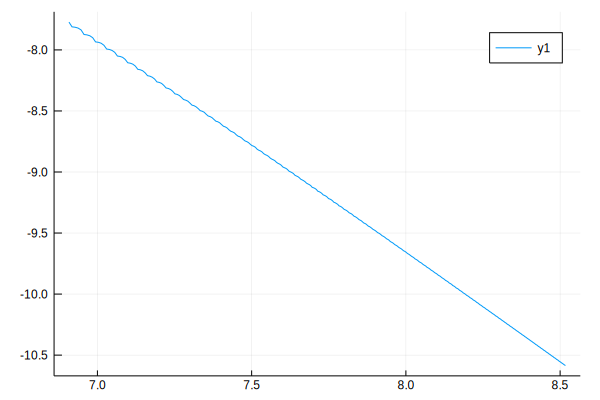

In [42]:
plot(log.(10*collect(100:500)),log.(Norm))

In [43]:
(log(Norm[1])-log(Norm[end]))/(log(100.0)-log(500))

-1.7479512933650836

In [48]:
h=1.0/convert(Float64,200);
mesh=map(x->h*x,collect(1:200));
t₀=1.0;
DARRAY=zeros(200);

In [50]:
NormT=[]

for N ∈ collect(70:150)
    τ=1.0/convert(Float64,N)
    u=blSol(mesh,t₀);
    umin=deepcopy(u);
    u=nSteps(N,umin,mesh,t₀,DARRAY,F,D,τ);
    NormT=vcat(NormT,L1(SSol(mesh,t₀+1.0),u));
    println(N)
end


70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


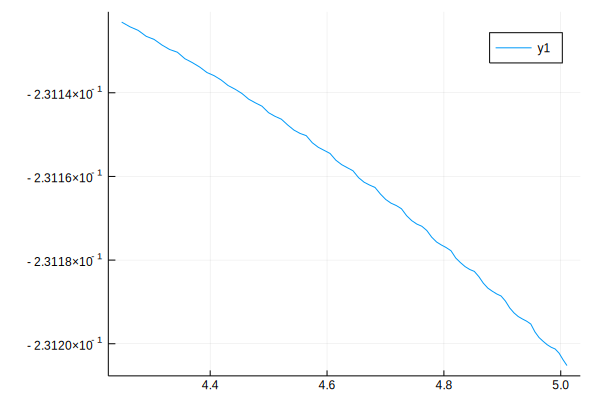

In [52]:
plot(log.(collect(70:150)),log.(NormT))

In [54]:
(log(NormT[1])-log(NormT[end]))/(log(70)-log(150))

-0.00010773165967429943

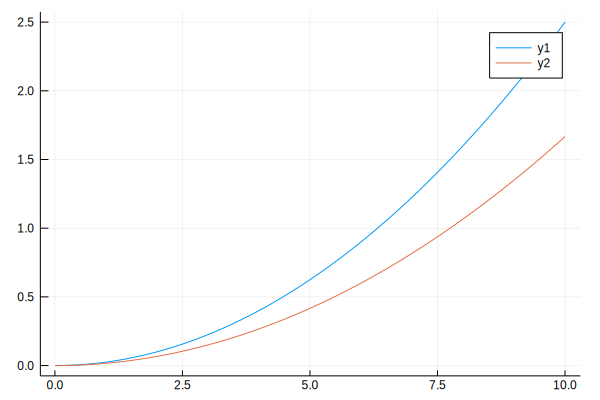

In [52]:
plot(mesh,SSol(mesh,t₀+100.0*τ))
plot!(mesh,SSol(mesh,t₀))